In [1]:
import pandas as pd
import configparser
import os
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 50)

In [2]:
## Using an ini file for credentials, otherwise providing defaults
uri = "bolt://localhost:7687"   # Hoặc thay đổi nếu cổng khác
username = "neo4j"              # Tên đăng nhập của Neo4j
password = "12345678"      # Mật khẩu của Neo4j

In [4]:
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience(uri, auth=(username, password))

In [5]:
# Machine Learning Training & Evaluation
# Get and Prepare Data
df = gds.run_cypher('''
    MATCH(u:User)
    RETURN u.guid AS guid,
        u.wccId AS wccId,
        u.fraudRisk AS fraudRisk,
        u.fraudMoneyTransfer AS fraudMoneyTransfer,
        u.sharedIdsDegree AS sharedIdsDegree,
        u.p2pSharedCardPageRank AS p2pSharedCardPageRank,
        u.p2pSentPageRank AS p2pSentPageRank,
        u.p2pReceivedWeightedPageRank AS p2pReceivedWeightedPageRank,
        u.p2pReceivedWeightedDegree AS p2pReceivedWeightedDegree,
        u.ipDegree AS ipDegree,
        u.cardDegree AS cardDegree,
        u.deviceDegree AS deviceDegree,
        u.communitySize AS communitySize,
        u.partOfCommunity AS partOfCommunity
''')
df

,guid,wccId,fraudRisk,fraudMoneyTransfer,sharedIdsDegree,p2pSharedCardPageRank,p2pSentPageRank,p2pReceivedWeightedPageRank,p2pReceivedWeightedDegree,ipDegree,cardDegree,deviceDegree,communitySize,partOfCommunity
0,be0222d26897046dc92ae2929d3427e7,0,0,0,0.0,0.150000,0.175463,0.414298,10.0,21.0,3.0,4.0,1,0
1,59515432f0e2e79b83e9524c94f7f86e,1,0,0,0.0,0.150000,0.310576,0.150422,10.0,7.0,1.0,1.0,1,0
2,ba1f4324c66ee093478d41a6826a3649,2,0,0,0.0,0.150000,0.277500,0.150000,160.0,8.0,2.0,1.0,1,0
3,8a18e1625e35a9f66abfd7bd2d04f0b3,3,0,0,0.0,0.150000,0.230177,0.319779,100.0,135.0,12.0,2.0,1,0
4,9f705a0107acc25a57f9e6aa8436a08e,4,0,0,0.0,0.150000,0.391428,0.150000,2703.6,169.0,9.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33726,f3693169dcc9064114a171c5c2f485b5,33726,0,0,0.0,0.150000,0.297005,0.451011,5.0,14.0,2.0,2.0,1,0
33727,10f7f048645c602de3fae7c2cf81b254,27912,0,0,1.0,0.999999,0.371382,1.632799,150.0,5.0,4.0,4.0,2,1
33728,d3a4469957800636802a8de4874af1bc,33728,0,0,0.0,0.150000,0.150000,0.277500,0.0,38.0,2.0,0.0,1,0
33729,4698ccb2e4b07b1974741f634115e49b,33729,0,0,0.0,0.150000,0.181054,0.170451,10.0,1.0,1.0,0.0,1,0


In [6]:
# X: Tập dữ liệu đặc trưng đầu vào cho mô hình, loại bỏ các cột không cần thiết:
# Loại bỏ fraudRisk, fraudMoneyTransfer (vì đây là mục tiêu dự đoán).
# Loại bỏ wccId và guid (không mang giá trị cho mô hình học máy).
# X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid', 'p2pSentPageRank', 'p2pReceivedWeightedPageRank','cardDegree','p2pReceivedWeightedDegree', 'p2pSharedCardPageRank', 'deviceDegree'])
X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid'])
# y: Biến mục tiêu (target variable):
# df.fraudRisk - df.fraudMoneyTransfer:
# Nếu fraudRisk = 1 và fraudMoneyTransfer = 0 → tài khoản nguy cơ rủi ro → y = 1.
# Nếu fraudRisk = 1 và fraudMoneyTransfer = 1 → tài khoản đã chuyển tiền gian lận → y = 0.
# Nếu fraudRisk = 0 → tài khoản an toàn → y = 0.
y = df.fraudRisk - df.fraudMoneyTransfer

In [7]:
print(X)

       sharedIdsDegree  p2pSharedCardPageRank  p2pSentPageRank  \
0                  0.0               0.150000         0.175463   
1                  0.0               0.150000         0.310576   
2                  0.0               0.150000         0.277500   
3                  0.0               0.150000         0.230177   
4                  0.0               0.150000         0.391428   
...                ...                    ...              ...   
33726              0.0               0.150000         0.297005   
33727              1.0               0.999999         0.371382   
33728              0.0               0.150000         0.150000   
33729              0.0               0.150000         0.181054   
33730              0.0               0.150000         0.185296   

       p2pReceivedWeightedPageRank  p2pReceivedWeightedDegree  ipDegree  \
0                         0.414298                       10.0      21.0   
1                         0.150422                       

In [8]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
33726    0
33727    0
33728    0
33729    0
33730    0
Length: 33731, dtype: int64


In [9]:
# Chia tập train và test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Dùng SMOTE để tăng mẫu gian lận cho mô hình 
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

Decision Tree - Accuracy: 0.8977
Precision: 0.9926
Recall: 0.8977
F1-score: 0.9404

Confusion Matrix:


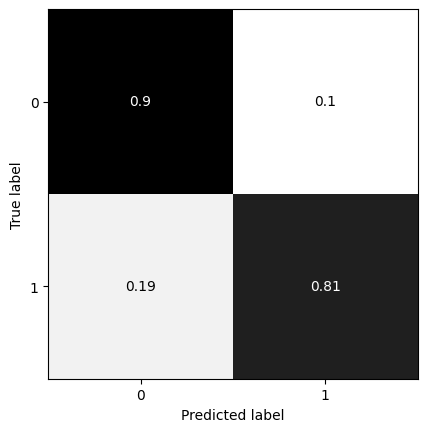

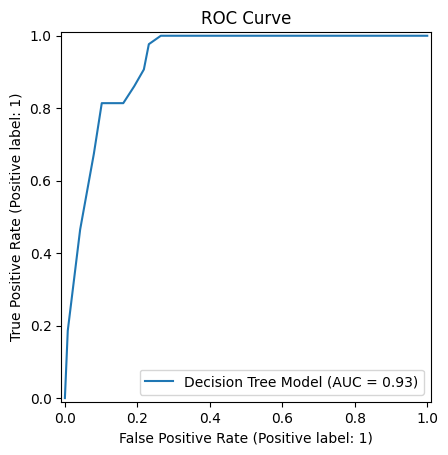

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Khởi tạo mô hình Decision Tree với các tham số tương tự Random Forest
dt_model = DecisionTreeClassifier(
    max_depth=5,            # Giới hạn độ sâu của cây
    random_state=0,         # Đảm bảo tái lập kết quả
    class_weight='balanced' # Cân bằng trọng số của các lớp
)

# Huấn luyện mô hình
dt_model.fit(X_train_balanced, y_train_balanced)

# Dự đoán trên tập kiểm tra
y_pred_dt = dt_model.predict(X_test)

# Đánh giá mô hình
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

# In kết quả
print(f"Decision Tree - Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-score: {f1_dt:.4f}")

# Hiển thị ma trận nhầm lẫn
print('\nConfusion Matrix:')
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_dt, display_labels=dt_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)

# Hiển thị ROC Curve
display = RocCurveDisplay.from_estimator(dt_model, X_test, y_test, name="Decision Tree Model")
_ = display.ax_.set_title("ROC Curve")


SVM (RBF Kernel) - Accuracy: 0.9114
Precision: 0.9881
Recall: 0.9114
F1-score: 0.9477

Confusion Matrix:


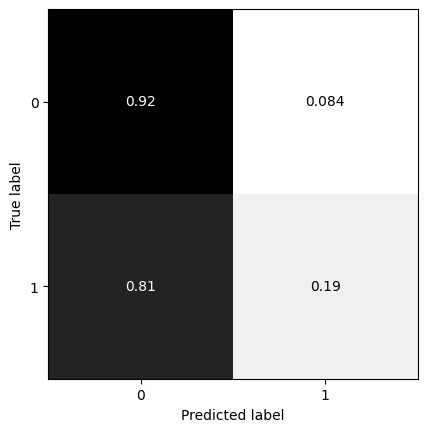

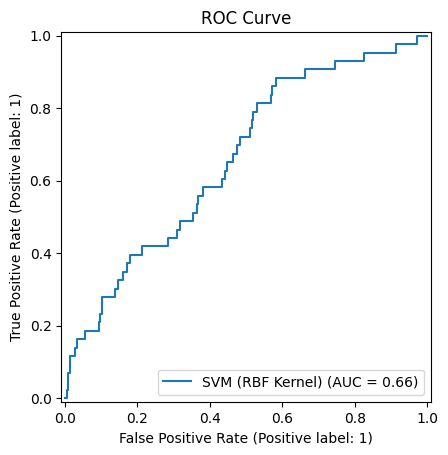

In [30]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Khởi tạo mô hình SVM với kernel RBF và cân bằng trọng số lớp
svm_model = SVC(
    kernel='rbf',         # Sử dụng kernel RBF
    class_weight='balanced', # Cân bằng trọng số lớp
    probability=True,      # Bật xác suất để vẽ ROC Curve
    random_state=0
)

# Huấn luyện mô hình
svm_model.fit(X_train_balanced, y_train_balanced)

# Dự đoán trên tập kiểm tra
y_pred_svm = svm_model.predict(X_test)

# Đánh giá mô hình
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

# In kết quả
print(f"SVM (RBF Kernel) - Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")

# Hiển thị ma trận nhầm lẫn
print('\nConfusion Matrix:')
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_svm, display_labels=svm_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)

# Hiển thị ROC Curve
display = RocCurveDisplay.from_estimator(svm_model, X_test, y_test, name="SVM (RBF Kernel)")
_ = display.ax_.set_title("ROC Curve")


KNN - Accuracy: 0.9143
Precision: 0.9893
Recall: 0.9143
F1-score: 0.9494

Confusion Matrix:


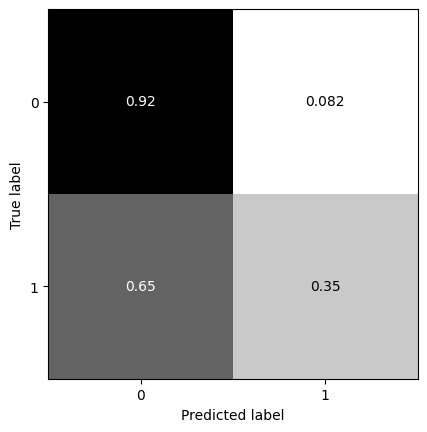

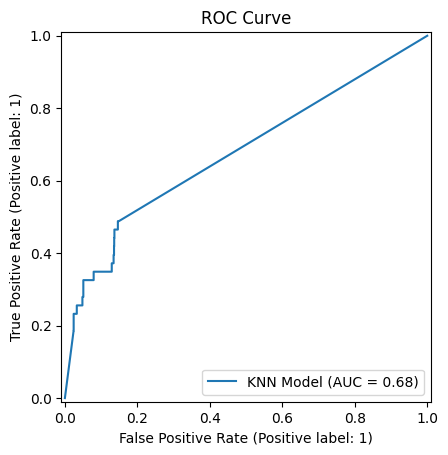

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Khởi tạo mô hình KNN
knn_model = KNeighborsClassifier(
    n_neighbors=7,      # Số lượng láng giềng k
    weights='distance', # Các điểm gần hơn sẽ có trọng số lớn hơn
    metric='minkowski'  # Mặc định, tương đương khoảng cách Euclidean khi p=2
)

# Huấn luyện mô hình
knn_model.fit(X_train_balanced, y_train_balanced)  # Huấn luyện lại mô hình trên tập dữ liệu SMOTE

# Dự đoán trên tập kiểm tra
y_pred_knn = knn_model.predict(X_test)

# Đánh giá mô hình
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

# In kết quả
print(f"KNN - Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1-score: {f1_knn:.4f}")

# Hiển thị ma trận nhầm lẫn
print('\nConfusion Matrix:')
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_knn, display_labels=knn_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)

# Hiển thị ROC Curve
display = RocCurveDisplay.from_estimator(knn_model, X_test, y_test, name="KNN Model")
_ = display.ax_.set_title("ROC Curve")


In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np 
from sklearn.neural_network import MLPClassifier

# Tính class weight
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print("Class Weights:", class_weight_dict)

# Tạo sample_weight cho từng sample
sample_weights = np.array([class_weight_dict[label] for label in y_train])

# Khởi tạo và huấn luyện MLP với sample_weight
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16), 
    activation='relu',
    alpha=0.01,
    solver='adam',
    max_iter=50,
    random_state=42,
    verbose=True
)

mlp.fit(X_train, y_train, sample_weight=sample_weights)

# Dự đoán và đánh giá
y_pred = mlp.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Hiển thị Confusion Matrix
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, mlp.predict(X_test), 
                                               display_labels=mlp.classes_,
                                               normalize='true', cmap='Greys', 
                                               colorbar=False)

Class Weights: {0: 0.5031324582338902, 1: 80.30952380952381}


TypeError: BaseMultilayerPerceptron.fit() got an unexpected keyword argument 'sample_weight'

In [23]:
# Vì không dùng được class weight nên chỉ dùng SMOTE để cân bằng dữ liệu 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Khởi tạo MLPClassifier giống Random Forest
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50), # Kiến trúc mạng với 2 tầng ẩn
    activation='relu',            # Hàm kích hoạt ReLU
    solver='adam',                # Tối ưu Adam
    alpha=0.01,                   # Regularization để giảm overfitting
    max_iter=500,                 # Tăng số vòng lặp
    random_state=0
)

# Huấn luyện mô hình trên dữ liệu đã cân bằng
mlp_model.fit(X_train_balanced, y_train_balanced)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 50), max_iter=500,
              random_state=0)

MLP - Accuracy: 0.8794
Precision: 0.9912
Recall: 0.8794
F1-score: 0.9300

Confusion Matrix:


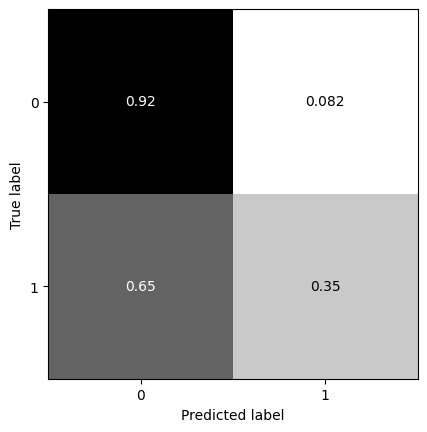

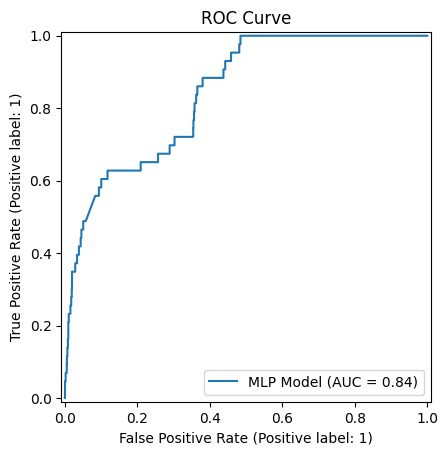

In [25]:
# Dự đoán trên tập kiểm tra
y_pred_mlp = mlp_model.predict(X_test)

# Đánh giá hiệu suất
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted')
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')

# In kết quả
print(f"MLP - Accuracy: {accuracy_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")
print(f"F1-score: {f1_mlp:.4f}")

# Hiển thị ma trận nhầm lẫn
print('\nConfusion Matrix:')
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_knn, display_labels=mlp_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)

# Hiển thị ROC Curve
display = RocCurveDisplay.from_estimator(mlp_model, X_test, y_test, name="MLP Model")
_ = display.ax_.set_title("ROC Curve")

Naïve Bayes - Accuracy: 0.8439
Precision: 0.9923
Recall: 0.8439
F1-score: 0.9095

Confusion Matrix:


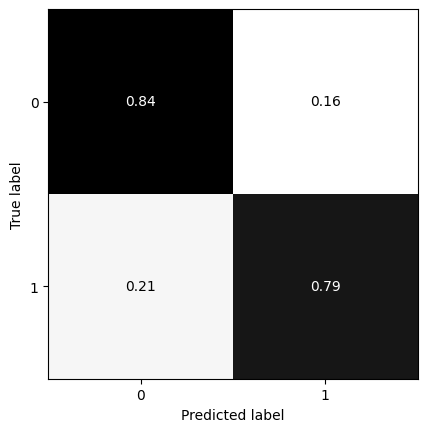

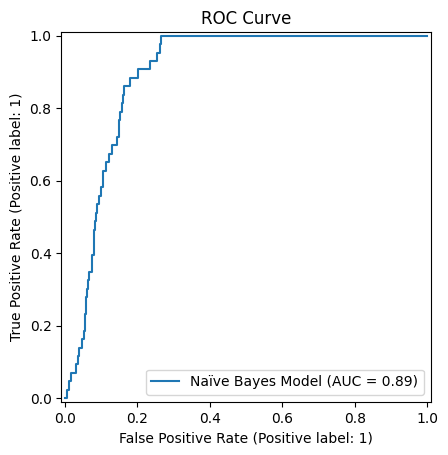

In [26]:
# Vì không có class weight nên dùng trọng số lớp class_prior cho mô hình naive bayes
# 
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Tính trọng số của từng lớp
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Chuyển trọng số thành xác suất lớp
class_prior = class_weights / class_weights.sum()

# Khởi tạo mô hình Naïve Bayes với class_prior
nb_model = GaussianNB(priors=class_prior)

# Huấn luyện mô hình
nb_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_nb = nb_model.predict(X_test)

# Đánh giá hiệu suất
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

# In kết quả
print(f"Naïve Bayes - Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1-score: {f1_nb:.4f}")

print('\nConfusion Matrix:')
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_nb, display_labels=nb_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)

display = RocCurveDisplay.from_estimator(nb_model, X_test, y_test, name="Naïve Bayes Model")
_ = display.ax_.set_title("ROC Curve")

Bagging - Accuracy: 0.8865
Precision: 0.9931
Recall: 0.8865
F1-score: 0.9340

Confusion Matrix:


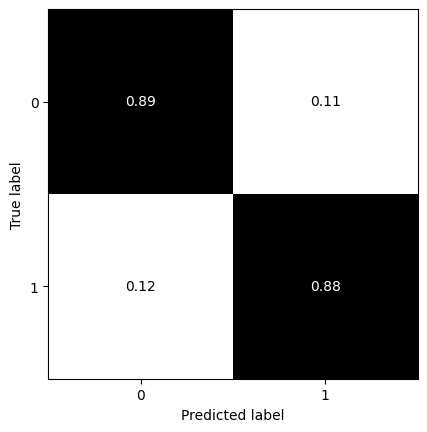

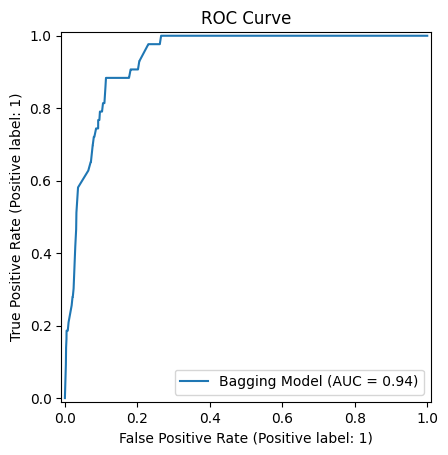

In [34]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Khởi tạo mô hình cây quyết định với class_weight='balanced'
base_tree = DecisionTreeClassifier(
    max_depth=5, 
    class_weight='balanced',  # Cân bằng dữ liệu trong Decision Tree
    random_state=42
)

# Khởi tạo mô hình Bagging với Decision Tree
bagging_model = BaggingClassifier(
    estimator=base_tree,  # Dùng Decision Tree đã điều chỉnh trọng số
    n_estimators=10,  # Số lượng cây trong Bagging
    bootstrap=True,  # Lấy mẫu có hoàn lại
    random_state=42,
    n_jobs=-1
)

bagging_model.fit(X_train_balanced, y_train_balanced)

y_pred_bagging = bagging_model.predict(X_test)

accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
precision_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

print(f"Bagging - Accuracy: {accuracy_bagging:.4f}")
print(f"Precision: {precision_bagging:.4f}")
print(f"Recall: {recall_bagging:.4f}")
print(f"F1-score: {f1_bagging:.4f}")

print('\nConfusion Matrix:')
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_bagging, display_labels=bagging_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)

display = RocCurveDisplay.from_estimator(bagging_model, X_test, y_test, name="Bagging Model")
_ = display.ax_.set_title("ROC Curve")

Random Forest - Accuracy: 0.8822
Precision: 0.9929
Recall: 0.8822
F1-score: 0.9316

Confusion Matrix:


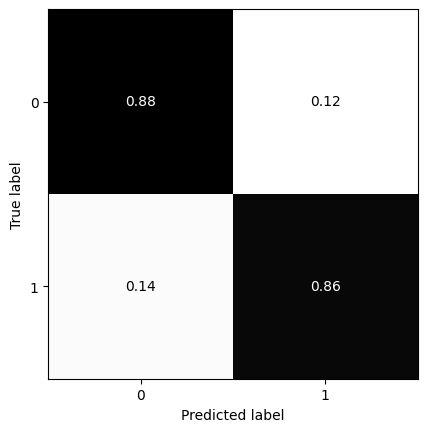

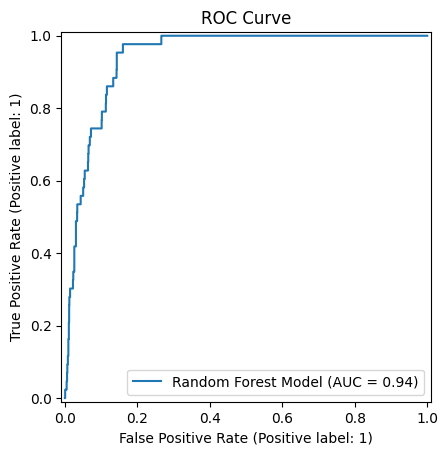

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Khởi tạo mô hình Random Forest với class_weight='balanced'
rf_model = RandomForestClassifier(
    n_estimators=500,   # Số lượng cây giống với Bagging
    max_depth=5,        # Giới hạn độ sâu để tránh overfitting
    bootstrap=True,     # Lấy mẫu có hoàn lại
    class_weight='balanced',  # Điều chỉnh trọng số lớp như Bagging
    random_state=0,
    n_jobs=-1
)

rf_model.fit(X_train_balanced, y_train_balanced)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Random Forest - Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

print('\nConfusion Matrix:')
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, display_labels=rf_model.classes_,
    normalize='true', cmap='Greys', colorbar=False
)

display = RocCurveDisplay.from_estimator(rf_model, X_test, y_test, name="Random Forest Model")
_ = display.ax_.set_title("ROC Curve")


Random Forest - Accuracy: 0.9941
Precision: 0.9930
Recall: 0.9941
F1-score: 0.9917

Confusion Matrix:


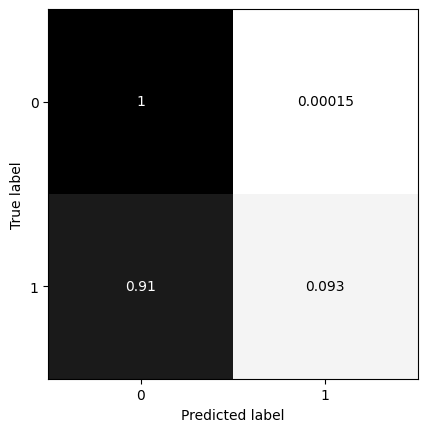

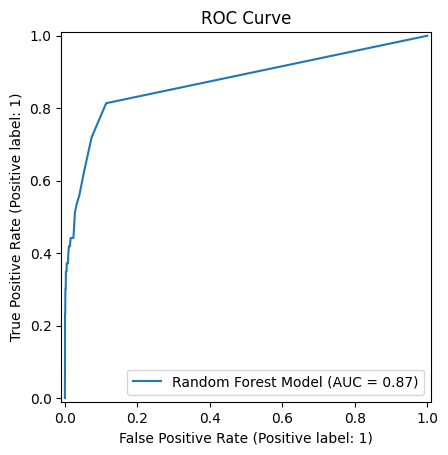

In [33]:
# Mô hình random forest 
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred_rf = clf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Random Forest - Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

print('\nConfusion Matrix:')
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, display_labels=clf.classes_,
    normalize='true', cmap='Greys', colorbar=False
)

display = RocCurveDisplay.from_estimator(clf, X_test, y_test, name="Random Forest Model")
_ = display.ax_.set_title("ROC Curve")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Các mô hình máy học
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

def hyperparameter_tuning_with_split(X, y):
    # Chia dữ liệu ban đầu thành train+valid và test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Chia tiếp train+valid thành train và validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
    )

    # Hiển thị kích thước các tập
    print("Kích thước tập:")
    print(f"Train: {X_train.shape}")
    print(f"Validation: {X_val.shape}")
    print(f"Test: {X_test.shape}")

    # Định nghĩa các mô hình và grid search
    models = {
        'Random Forest': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [5, 10, 15, None],
                'min_samples_split': [2, 5, 10],
                'criterion': ['gini', 'entropy']
            }
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'max_depth': [3, 5, 7, None],
                'min_samples_split': [2, 5, 10],
                'criterion': ['gini', 'entropy']
            }
        },
        'SVM': {
            'model': SVC(probability=True),
            'params': {
                'kernel': ['rbf', 'linear', 'poly'],
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.1, 1]
            }
        }
    }

    # Kết quả lưu trữ
    results = {}

    # Cấu hình cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Vòng lặp qua từng mô hình
    for name, config in models.items():
        # Tạo pipeline với scaling
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', config['model'])
        ])

        # Thực hiện Grid Search trên tập train
        grid_search = GridSearchCV(
            estimator=pipeline, 
            param_grid={f'classifier__{k}': v for k, v in config['params'].items()},
            cv=cv, 
            scoring='f1',
            n_jobs=-1
        )

        # Fit mô hình
        grid_search.fit(X_train, y_train)

        # Lấy mô hình tốt nhất
        best_model = grid_search.best_estimator_

        # Dự đoán trên các tập
        y_train_pred = best_model.predict(X_train)
        y_val_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)

        # Đánh giá trên các tập
        print(f"\n{name} - Đánh giá mô hình:")
        print("Best Parameters:", grid_search.best_params_)
        
        print("\nKết quả trên tập Train:")
        print(classification_report(y_train, y_train_pred))
        
        print("\nKết quả trên tập Validation:")
        print(classification_report(y_val, y_val_pred))
        
        print("\nKết quả trên tập Test:")
        print(classification_report(y_test, y_test_pred))

        # Lưu kết quả
        results[name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'train_f1': f1_score(y_train, y_train_pred),
            'val_f1': f1_score(y_val, y_val_pred),
            'test_f1': f1_score(y_test, y_test_pred)
        }

    return results

# Hàm vẽ biểu đồ so sánh F1-score
def plot_f1_scores(results):
    model_names = list(results.keys())
    train_f1 = [results[model]['train_f1'] for model in model_names]
    val_f1 = [results[model]['val_f1'] for model in model_names]
    test_f1 = [results[model]['test_f1'] for model in model_names]

    x = np.arange(len(model_names))
    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar(x - width, train_f1, width, label='Train F1')
    plt.bar(x, val_f1, width, label='Validation F1')
    plt.bar(x + width, test_f1, width, label='Test F1')

    plt.xlabel('Mô hình')
    plt.ylabel('F1 Score')
    plt.title('So sánh F1 Score giữa các tập')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Sử dụng
# Giả sử X, y là dữ liệu của bạn
# results = hyperparameter_tuning_with_split(X, y)
# plot_f1_scores(results)